In [207]:
# preprocessing
import pandas as pd
import numpy as np
import json
import time
from tqdm import tqdm
import itertools 
pd.set_option('display.max_columns', None)
from math import log # IDF 계산을 위해

# text prep
import re
from string import punctuation
import ast # str.list to list
from eunjeon import Mecab # tokenizing

# wordcloud
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# plot!
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
font_path = 'c:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
#한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
#ticks에 적용될 한글 폰트
font_ticks = fm.FontProperties(fname=font_path, size=10)
#title에 적용될 한글 폰트
font_title = fm.FontProperties(fname=font_path, size=13)

In [208]:
start = time.time()
dat = pd.read_csv('./data/article_dat.csv')
end = time.time()
print('take %.2f time!'%(end-start))

take 0.37 time!


In [209]:
dat.head()

,media_name,article_original,abstractive,extractive
0,디지털타임스,"['우리나라 수출이 지난달까지 9개월 연속 감소했다.', '반도체, 석유화학 등 주...",['산업통상자원부는 8월 수출이 전년도 같은 달보다 13.6% 줄어든 442억달러로...,"[3, 4, 15]"
1,아주경제,"[""KT는 현지시간으로 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 ...","['3일, KT는 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가전 ...","[0, 4, 6]"
2,매일경제,['한국의 11년 만에 세계청소년야구선수권대회(U-18 야구 월드컵) 우승에 비상등...,['세계청소년야구선수권대회에 참가한 한국 청소년야구대표팀이 슈퍼라운드 첫 경기만에 ...,"[0, 2, 12]"
3,매일경제,"[""국제구호개발 NGO 굿네이버스(회장 양진옥)가 유산기부자 모임 '더네이버스레거시...","[""국제구호개발 NGO 굿네이버스가 유산 기부를 원하는 사람들에게 법률, 금융 등 ...","[0, 6, 7]"
4,디지털타임스,"['홍남기 경제부총리 겸 기획재정부 장관은 16일 ""주택을 통한 불로소득은 어떠한 ...","['홍남기 경제부총리는 16일 ""주택을 통한 불로소득은 어떠한 경우에도 절대 허용하...","[0, 3, 10]"


## 미디어별 개수 (stratified sampling으로 추출한 과정 설명하고 그래프 보여주기 )
## 특수문자, white space 날리는 과정

In [210]:
media_num = dat['media_name'].value_counts().rename_axis('unique_values').to_frame('counts')
media_num.reset_index(inplace = True)
media_num.columns = ['media', 'counts']
media_num

,media,counts
0,매일경제,2447
1,디지털타임스,2291
2,아주경제,2287
3,머니투데이,2134
4,중부일보,1867


<AxesSubplot:xlabel='media', ylabel='counts'>

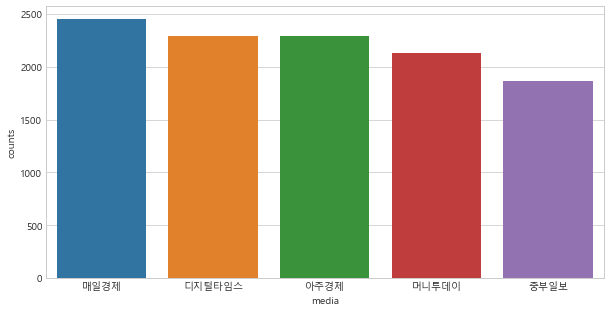

In [211]:
sns.barplot(x = 'media', y = 'counts', data=media_num)

In [212]:
# str.list to list

def transform_strtolist(dat):
    return ast.literal_eval(dat)

dat['article_original'] = dat['article_original'].apply(transform_strtolist)
dat['abstractive'] = dat['abstractive'].apply(transform_strtolist)
dat['extractive'] = dat['extractive'].apply(transform_strtolist)

In [213]:
## pattern들 정의
import re
from string import punctuation

# 한글, 영어, 숫자, 살릴 특수문자들이 아닌 기호들 날리기
patmain = re.compile(r"[^(A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ+@$?\-!<&;()=/_>\"\'*%#`.:~\\)]") 

# 특수문자 날리기
patspec = re.compile(r"[+@$?\-!<&;()=/_>\"\'*%#`.:~\\]") #,

# white space 2번 이상 반복되면 날리기
patwhite = re.compile(r'\s{2,}') 

def cleaning(doc):
    for sen in doc:
        sen = patmain.sub(' ',sen)
        sen = patspec.sub(' ',sen)
        sen = patwhite.sub(' ', sen)
    return doc

dat['article_original'] = dat['article_original'].apply(cleaning)

In [214]:
dat['article_original'][0]

['우리나라 수출이 지난달까지 9개월 연속 감소했다.',
 '반도체, 석유화학 등 주력 수출품목 부진 탓이다.',
 '일본 수출규제가 우리 수출에 미치는 영향은 아직은 미미한 것으로 나타났다.',
 '1일 산업통상자원부에 따르면 8월 수출은 지난해 같은 달보다 13.6% 줄어든 442억달러로 집계됐다.',
 '수출은 지난해 12월 1.7% 감소한 이후 9개월 연속 감소세다.',
 '산업부 측은 "미중 무역분쟁 심화 등 대외 여건이 악화하고 전년도 기저효과, 조업일 감소(-0.5일) 등이 복합적으로 영향을 미쳤다"고 설명했다.',
 '단가 하락 영향으로 반도체(-30.7%), 석유화학(-19.2%), 석유제품(-14.1%) 등 주력 품목의 수출이 부진했다.',
 '반도체는 D램 가격이 전년 동월에 비해 54%나 하락했다.',
 '자동차(4.6%)·선박(168.6%)을 비롯해 이차전지(3.6%)·농수산식품(5.7%)·화장품(1.1%) 등은 수출이 늘었다.',
 '특히 자동차 수출은 지난 4월 이후 5개월 연속 증가했는데, 2017년 6월 이후 처음으로 5개월 연속 증가다.',
 '또 1∼8월 누적 수출물량은 지난해 같은 기간에 비해 0.7% 늘었다.',
 '지역별로 보면 중국(-21.3), 미국(-6.7%), 일본(-6.2%)은 감소했지만, 아세안(ASEAN·1.9%), 독립국가연합(CIS·8.8%) 등 신남방·신북방 수출은 늘었다.',
 '중국 수출은 10개월 연속 감소한 반면 아세안과 CIS의 수출은 각각 2개월 연속, 14개월 연속 증가했다.',
 '8월 일본 수출은 6.2% 감소했지만, 7월부터 시작된 일본의 수출규제에 따른 영향은 아직 제한적인 것으로 나타났다.',
 '7월 기준으로 불화수소, 포토레지스트 등 일본이 수출규제에 들어간 반도체 디스플레이 3개 소재 품목의 수입액은 8000만달러로, 전체 일본 수입액(41억6000만 달러)에서 차지하는 비중이 1.8%에 불과했다.',
 '산업부 관계자는 "일본의 3개 소재 품목 수출규제가 실제 한국 기업의 생

## 기사의 길이 , 사용 요약 문장 PLOT ( 전체, 미디어별 )

In [215]:
def get_len(sen):
    return len(sen)

dat['article_len'] = dat['article_original'].apply(get_len)
dat['ext_len'] = dat['extractive'].apply(get_len)

In [216]:
dat.head()

,media_name,article_original,abstractive,extractive,article_len,ext_len
0,디지털타임스,"[우리나라 수출이 지난달까지 9개월 연속 감소했다., 반도체, 석유화학 등 주력 수...",[산업통상자원부는 8월 수출이 전년도 같은 달보다 13.6% 줄어든 442억달러로 ...,"[3, 4, 15]",18,3
1,아주경제,[KT는 현지시간으로 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가...,"[3일, KT는 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가전 I...","[0, 4, 6]",24,3
2,매일경제,[한국의 11년 만에 세계청소년야구선수권대회(U-18 야구 월드컵) 우승에 비상등이...,[세계청소년야구선수권대회에 참가한 한국 청소년야구대표팀이 슈퍼라운드 첫 경기만에 대...,"[0, 2, 12]",26,3
3,매일경제,[국제구호개발 NGO 굿네이버스(회장 양진옥)가 유산기부자 모임 '더네이버스레거시클...,"[국제구호개발 NGO 굿네이버스가 유산 기부를 원하는 사람들에게 법률, 금융 등 맞...","[0, 6, 7]",20,3
4,디지털타임스,"[홍남기 경제부총리 겸 기획재정부 장관은 16일 ""주택을 통한 불로소득은 어떠한 경...","[홍남기 경제부총리는 16일 ""주택을 통한 불로소득은 어떠한 경우에도 절대 허용하지...","[0, 3, 10]",11,3


In [217]:
def get_1st_ext(dat):
    return dat[0]

def get_2nd_ext(dat):
    return dat[1]

def get_3rd_ext(dat):
    return dat[2]

dat['ext_1st'] = dat['extractive'].apply(get_1st_ext)
dat['ext_2nd'] = dat['extractive'].apply(get_2nd_ext)
dat['ext_3rd'] = dat['extractive'].apply(get_3rd_ext)

문장의 최소 개수 : 4
문장의 최대 개수 : 53
문장의 평균 개수 : 13.881189914746962


c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


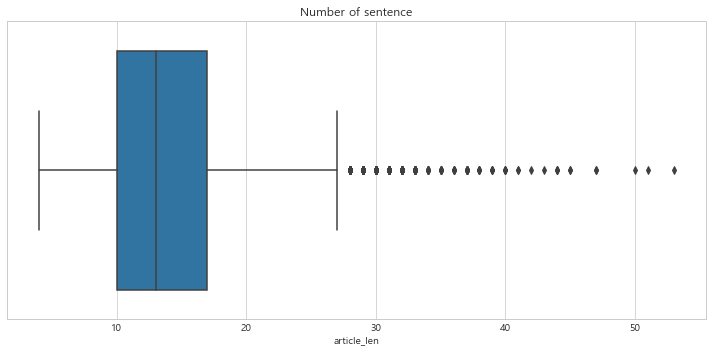

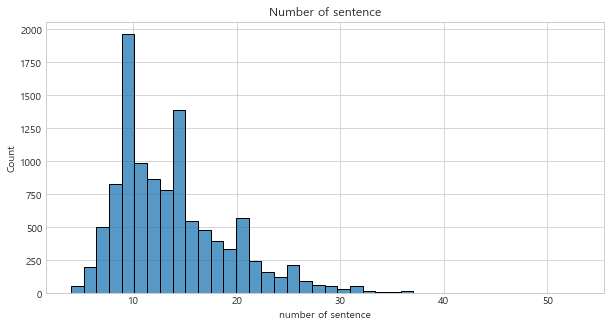

In [218]:
# 개수 분포 출력
# dat['article_len'] = [len(s.split()) for s in dat['article_ogtext']]
# dat['article_len'] = [len(s.split()) for s in dat['abstractive']]

print('문장의 최소 개수 : {}'.format(np.min(dat['article_len'])))
print('문장의 최대 개수 : {}'.format(np.max(dat['article_len'])))
print('문장의 평균 개수 : {}'.format(np.mean(dat['article_len'])))

# plt.subplot(1,1)
# sns.boxenplot(dat['ext_len'])
# plt.title('Summary')
plt.subplot(1,1,1)
sns.boxplot(dat['article_len'])
plt.title('Number of sentence')
plt.tight_layout()
plt.show()

sns.histplot(dat['article_len'], bins=40)
plt.title('Number of sentence')
plt.xlabel('number of sentence')
plt.ylabel('Count')
plt.show()

In [13]:
dat['media_name'].unique()

array(['디지털타임스', '아주경제', '매일경제', '머니투데이', '중부일보'], dtype=object)

In [14]:
dat.head()

,media_name,article_original,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd
0,디지털타임스,"[우리나라 수출이 지난달까지 9개월 연속 감소했다., 반도체, 석유화학 등 주력 수...",[산업통상자원부는 8월 수출이 전년도 같은 달보다 13.6% 줄어든 442억달러로 ...,"[3, 4, 15]",18,3,3,4,15
1,아주경제,[KT는 현지시간으로 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가...,"[3일, KT는 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가전 I...","[0, 4, 6]",24,3,0,4,6
2,매일경제,[한국의 11년 만에 세계청소년야구선수권대회(U-18 야구 월드컵) 우승에 비상등이...,[세계청소년야구선수권대회에 참가한 한국 청소년야구대표팀이 슈퍼라운드 첫 경기만에 대...,"[0, 2, 12]",26,3,0,2,12
3,매일경제,[국제구호개발 NGO 굿네이버스(회장 양진옥)가 유산기부자 모임 '더네이버스레거시클...,"[국제구호개발 NGO 굿네이버스가 유산 기부를 원하는 사람들에게 법률, 금융 등 맞...","[0, 6, 7]",20,3,0,6,7
4,디지털타임스,"[홍남기 경제부총리 겸 기획재정부 장관은 16일 ""주택을 통한 불로소득은 어떠한 경...","[홍남기 경제부총리는 16일 ""주택을 통한 불로소득은 어떠한 경우에도 절대 허용하지...","[0, 3, 10]",11,3,0,3,10


c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

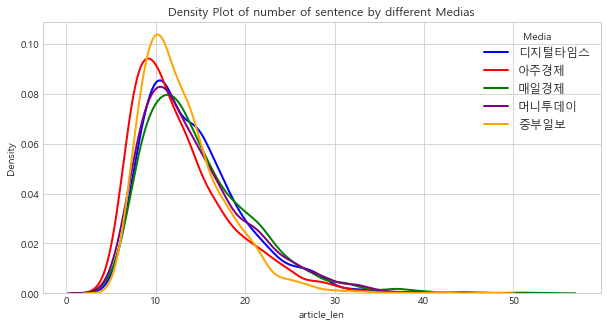

In [219]:
## article_len, ext_len media 별로 겹쳐 그리기 -> 미디어 별로 기사의 길이는 비슷한 모습을 보인다.

grp_col_dict = {'디지털타임스' : 'blue',
                '아주경제' : 'red',
                '매일경제' : 'green',
                '머니투데이' : 'purple',
                '중부일보' : 'orange'}

# for loop of species group
for group in grp_col_dict:
    # subset of group
    subset = dat[dat['media_name'] == group]
    # histogram and kernel density curve
    sns.distplot(subset['article_len'], 
                    hist = False, # histogram
                    kde = True,  # density curve
                    kde_kws = {'linewidth': 2}, 
                    color = grp_col_dict[group],
                    label = group)

# setting plot format
plt.title('Density Plot of number of sentence by different Medias')
plt.xlabel('article_len')
plt.ylabel('Density')

plt.legend(prop={'size': 12}, title = 'Media')


c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

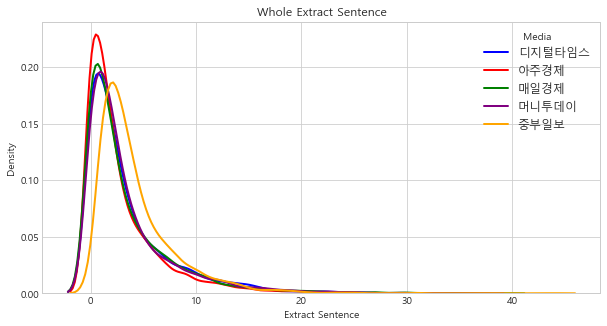

In [16]:
grp_col_dict = {'디지털타임스' : 'blue',
                '아주경제' : 'red',
                '매일경제' : 'green',
                '머니투데이' : 'purple',
                '중부일보' : 'orange'}

# for loop of species group
for group in grp_col_dict:
    # subset of group
    subset = dat[dat['media_name'] == group]
    extlist = []
    for ext in subset['extractive']:
        for _ in ext:
            extlist.append(_)
    # histogram and kernel density curve
    sns.distplot(extlist, 
                    hist = False, # histogram
                    kde = True,  # density curve
                    kde_kws = {'linewidth': 2}, 
                    color = grp_col_dict[group],
                    label = group)

# setting plot format
plt.title('Whole Extract Sentence')
plt.xlabel('Extract Sentence')
plt.ylabel('Density')

plt.legend(prop={'size': 12}, title = 'Media')

c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

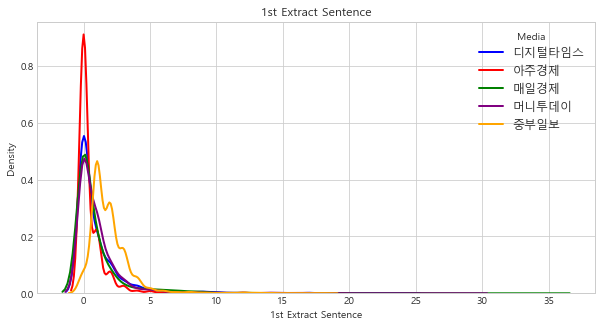

In [17]:
grp_col_dict = {'디지털타임스' : 'blue',
                '아주경제' : 'red',
                '매일경제' : 'green',
                '머니투데이' : 'purple',
                '중부일보' : 'orange'}

# for loop of species group
for group in grp_col_dict:
    # subset of group
    subset = dat[dat['media_name'] == group]
    # histogram and kernel density curve
    sns.distplot(subset['ext_1st'], 
                    hist = False, # histogram
                    kde = True,  # density curve
                    kde_kws = {'linewidth': 2}, 
                    color = grp_col_dict[group],
                    label = group)

# setting plot format
plt.title('1st Extract Sentence')
plt.xlabel('1st Extract Sentence')
plt.ylabel('Density')

plt.legend(prop={'size': 12}, title = 'Media')

c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

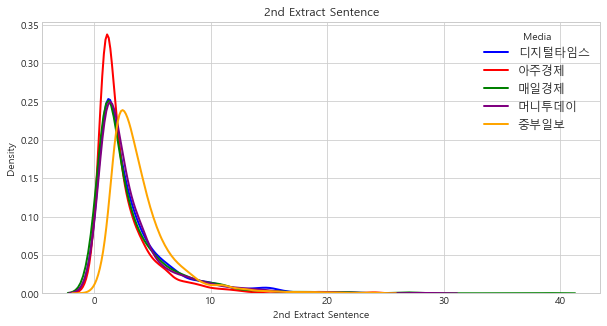

In [18]:
grp_col_dict = {'디지털타임스' : 'blue',
                '아주경제' : 'red',
                '매일경제' : 'green',
                '머니투데이' : 'purple',
                '중부일보' : 'orange'}

# for loop of species group
for group in grp_col_dict:
    # subset of group
    subset = dat[dat['media_name'] == group]
    # histogram and kernel density curve
    sns.distplot(subset['ext_2nd'], 
                    hist = False, # histogram
                    kde = True,  # density curve
                    kde_kws = {'linewidth': 2}, 
                    color = grp_col_dict[group],
                    label = group)

# setting plot format
plt.title('2nd Extract Sentence')
plt.xlabel('2nd Extract Sentence')
plt.ylabel('Density')

plt.legend(prop={'size': 12}, title = 'Media')

c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

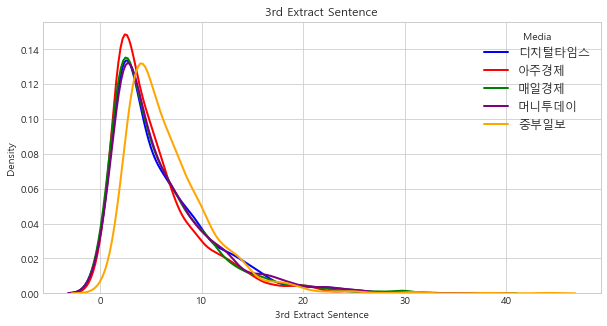

In [19]:
grp_col_dict = {'디지털타임스' : 'blue',
                '아주경제' : 'red',
                '매일경제' : 'green',
                '머니투데이' : 'purple',
                '중부일보' : 'orange'}

# for loop of species group
for group in grp_col_dict:
    # subset of group
    subset = dat[dat['media_name'] == group]
    # histogram and kernel density curve
    sns.distplot(subset['ext_3rd'], 
                    hist = False, # histogram
                    kde = True,  # density curve
                    kde_kws = {'linewidth': 2}, 
                    color = grp_col_dict[group],
                    label = group)

# setting plot format
plt.title('3rd Extract Sentence')
plt.xlabel('3rd Extract Sentence')
plt.ylabel('Density')

plt.legend(prop={'size': 12}, title = 'Media')

In [18]:
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

100%|██████████████████████████████████████████████████████████████████████████████| 1867/1867 [01:20<00:00, 23.27it/s]


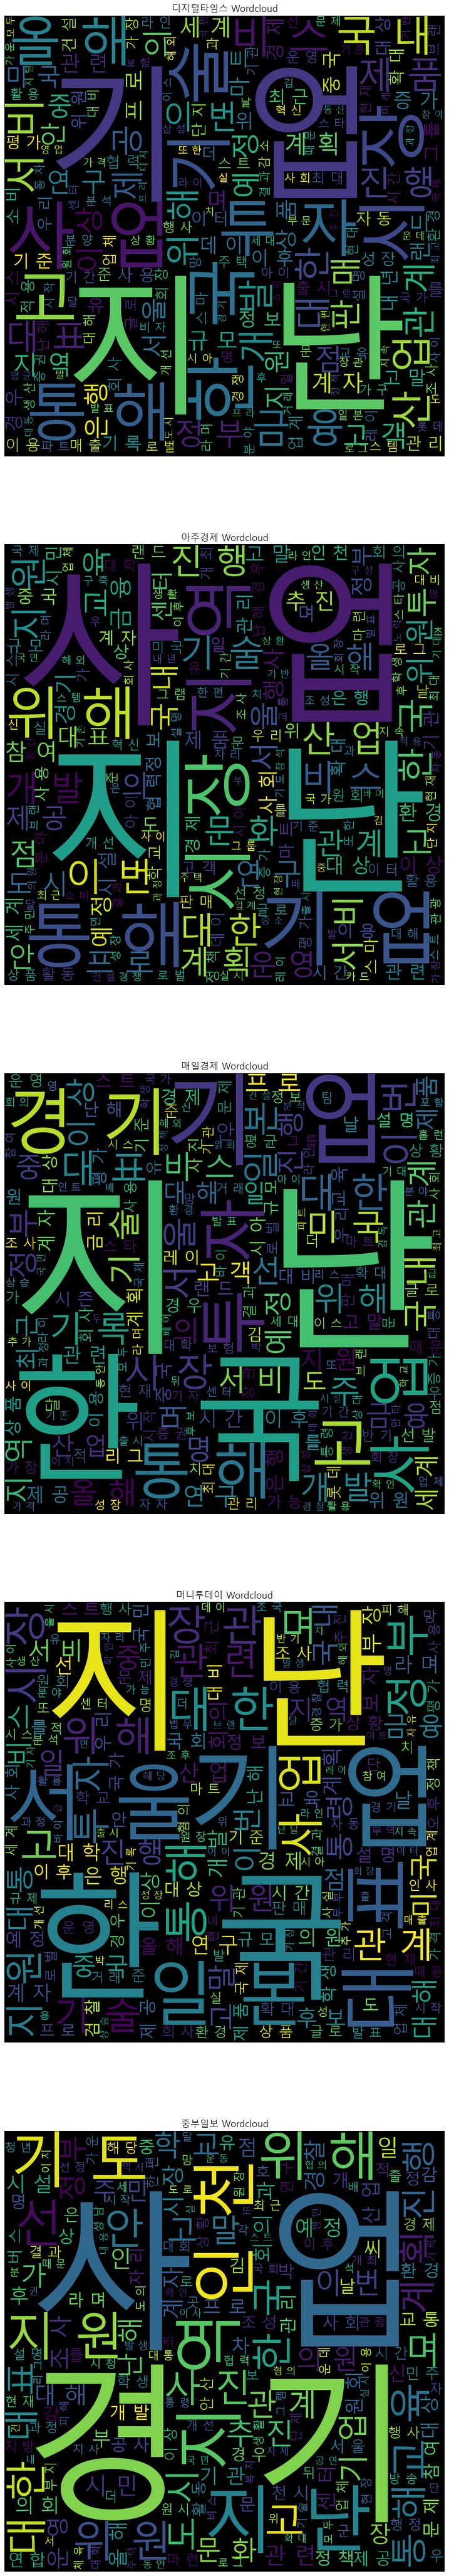

In [61]:
## wordcloud of each media

okt = Okt()
stopwords = set(STOPWORDS) 
# stopwords.add('지'); stopwords.add('난');
stopwords.add('등'); stopwords.add('수')
stopwords.add('및'); stopwords.add('전'); stopwords.add('것')

medialist = dat['media_name'].unique().tolist()

fig = plt.figure(figsize=(15, 5*15))
for n, media in enumerate(medialist):
    subset = dat.loc[dat['media_name'] == media]
    subset.reset_index(drop=True, inplace=True) ## must have to do
    plt.subplot(5, 1, n+1)
    oktlit = ''
    for i in tqdm(range(len(subset['article_original']))):
        oktlit = oktlit + (','.join(okt.nouns(','.join(subset['article_original'][i]))))

    oktlit = list(oktlit)
    
    wc = WordCloud(font_path=font_path,stopwords=stopwords,background_color='black',
               width=1000,height=1000).generate(' '.join(oktlit))

    plt.imshow(wc, interpolation='lanczos') # 이미지의 부드럽기 정도
    plt.title('%s Wordcloud'%(media), size = 15)
    plt.axis('off') # x y 축 숫자 제거

In [15]:
dat.head()

,media_name,article_original,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd
0,디지털타임스,"[우리나라 수출이 지난달까지 9개월 연속 감소했다., 반도체, 석유화학 등 주력 수...",[산업통상자원부는 8월 수출이 전년도 같은 달보다 13.6% 줄어든 442억달러로 ...,"[3, 4, 15]",18,3,3,4,15
1,아주경제,[KT는 현지시간으로 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가...,"[3일, KT는 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가전 I...","[0, 4, 6]",24,3,0,4,6
2,매일경제,[한국의 11년 만에 세계청소년야구선수권대회(U-18 야구 월드컵) 우승에 비상등이...,[세계청소년야구선수권대회에 참가한 한국 청소년야구대표팀이 슈퍼라운드 첫 경기만에 대...,"[0, 2, 12]",26,3,0,2,12
3,매일경제,[국제구호개발 NGO 굿네이버스(회장 양진옥)가 유산기부자 모임 '더네이버스레거시클...,"[국제구호개발 NGO 굿네이버스가 유산 기부를 원하는 사람들에게 법률, 금융 등 맞...","[0, 6, 7]",20,3,0,6,7
4,디지털타임스,"[홍남기 경제부총리 겸 기획재정부 장관은 16일 ""주택을 통한 불로소득은 어떠한 경...","[홍남기 경제부총리는 16일 ""주택을 통한 불로소득은 어떠한 경우에도 절대 허용하지...","[0, 3, 10]",11,3,0,3,10


In [16]:
# dat.to_csv('./data/dat_before_split.csv', index=False)

## Split Train, Val, Test ( Stratified )

In [133]:
dat = pd.read_csv('./data/dat_before_split.csv')
dat.head()

,media_name,article_original,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd
0,디지털타임스,"['우리나라 수출이 지난달까지 9개월 연속 감소했다.', '반도체, 석유화학 등 주...",['산업통상자원부는 8월 수출이 전년도 같은 달보다 13.6% 줄어든 442억달러로...,"[3, 4, 15]",18,3,3,4,15
1,아주경제,"[""KT는 현지시간으로 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 ...","['3일, KT는 내달 6일부터 11일까지 독일 베를린에서 열리는 유럽 최대 가전 ...","[0, 4, 6]",24,3,0,4,6
2,매일경제,['한국의 11년 만에 세계청소년야구선수권대회(U-18 야구 월드컵) 우승에 비상등...,['세계청소년야구선수권대회에 참가한 한국 청소년야구대표팀이 슈퍼라운드 첫 경기만에 ...,"[0, 2, 12]",26,3,0,2,12
3,매일경제,"[""국제구호개발 NGO 굿네이버스(회장 양진옥)가 유산기부자 모임 '더네이버스레거시...","[""국제구호개발 NGO 굿네이버스가 유산 기부를 원하는 사람들에게 법률, 금융 등 ...","[0, 6, 7]",20,3,0,6,7
4,디지털타임스,"['홍남기 경제부총리 겸 기획재정부 장관은 16일 ""주택을 통한 불로소득은 어떠한 ...","['홍남기 경제부총리는 16일 ""주택을 통한 불로소득은 어떠한 경우에도 절대 허용하...","[0, 3, 10]",11,3,0,3,10


In [134]:
# str.list to list

def transform_strtolist(dat):
    return ast.literal_eval(dat)

dat['article_original'] = dat['article_original'].apply(transform_strtolist)
dat['abstractive'] = dat['abstractive'].apply(transform_strtolist)
dat['extractive'] = dat['extractive'].apply(transform_strtolist)

In [135]:
from sklearn.model_selection import StratifiedShuffleSplit

sp = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sp.split(dat, dat["media_name"]):
    dat_train = dat.iloc[train_idx]
    dat_test = dat.iloc[test_idx]

for train_idx, val_idx in sp.split(dat_train, dat_train["media_name"]):
    train_dat = dat_train.iloc[train_idx]
    val_dat = dat_train.iloc[val_idx]

In [136]:
dat_train.shape, dat_test.shape

((8820, 9), (2206, 9))

In [137]:
train_dat.shape, val_dat.shape

((7056, 9), (1764, 9))

In [138]:
train_dat.reset_index(inplace=True)
val_dat.reset_index(inplace=True)
dat_train.reset_index(inplace=True)
dat_test.reset_index(inplace=True)

## Make Derived Variable

### 1) 각 media 별로 중요 문장으로 선택하는 bias를 반영!
### 2) 새로운 df에 'article_original'의 문장을 하나씩 빼서 저장 + label 생성 + 'first' 컬럼 생성

- label : sentence 내에서 선택된 문장 (target)
- new df는 'article_original', 'article_sent', 'article_token', 'label'이 들어갈 것임 (3번에서 토큰화 진행, 피처구축은 그 이후)
- extractive 값에 포함되는 sentence 번호에 1, 아니면 0 부여
- 뒤에서 이용할 피처 중 하나인 'first'(기사의 첫 번째 문장)이면 1, 아니면 0 부여하는 컬럼 생성

In [87]:
train_dat.head()

,index,media_name,article_original,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd
0,7659,중부일보,[조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을...,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5
1,1643,매일경제,[모나미와 신성통상이 일본 제품 불매운동에 대한 수혜주로 거론되며 주가가 크게 움직...,"[소셜네트워크서비스(SNS)와 포털사이트 증권 정보방에서 주방용품, 완구, 콘돔 제...","[0, 1, 2]",14,3,0,1,2
2,9404,매일경제,"[용석우 삼성전자 영상디스플레이사업부 상무가 삼성 8K TV를 소개하고 있다., 삼...","[삼성전자가 17일 8K TV시장을 본격화하겠다고 밝히며, LG 나노셀 8K TV의...","[1, 7, 4]",17,3,1,7,4
3,5422,중부일보,"[김재득, 이낙연 국무총리는 9일 강원도 산불을 계기로 ""국가적 총력 대응이 얼마나...",[이낙연 국무총리는 9일 정부서울청사에서 주최한 강원도 산불 관계장관회의에서 강원도...,"[2, 5, 9]",11,3,2,5,9
4,5577,디지털타임스,[듀폰 전자재료가 한국을 '플렉서블(휘는)' 디스플레이 등 미래 IT(정보기술) 신...,[지난 9월 듀폰 전자재료가 급성장하는 플렉시블 디스플레이 시장에 대응하려 액상 폴...,"[0, 10, 11]",12,3,0,10,11


In [43]:
# define dataset
mediatrain_dat = train_dat.loc[train_dat['media_name'] == '중부일보']
mediatrain_dat.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

# define bias vector
fullext = []

for i, ext in enumerate(mediatrain_dat['extractive']):
    for element in ext:
        fullext.append(element)

pdfullext = pd.DataFrame({'number' : fullext})
count = pdfullext['number'].value_counts()
countdf = count.rename_axis('unique_values').reset_index(name='counts')
countdf = pd.DataFrame(countdf)
countdf.sort_values(by = ['unique_values'], axis=0, inplace=True)
countdf

,unique_values,counts
10,0,78
2,1,561
0,2,715
1,3,598
3,4,444
4,5,282
5,6,202
6,7,156
7,8,133
8,9,83


In [139]:
## make whole bias of media!!

def make_whole_bias(train_dat, dat):
    
    biasdat = pd.DataFrame(columns=['bias', 'id'])
    
    ### make bias info from train!
    medialist = dat['media_name'].unique().tolist()
    
    for media in medialist:

        # define train dataset
        mediadat = train_dat.loc[train_dat['media_name'] == media]
        mediadat.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        # define bias vector
        fullext = []

        for i, ext in enumerate(mediadat['extractive']):
            for element in ext:
                fullext.append(element)

        pdfullext = pd.DataFrame({'number' : fullext})
        count = pdfullext['number'].value_counts()
        countdf = count.rename_axis('unique_values').reset_index(name='counts')
        countdf = pd.DataFrame(countdf)
        countdf.sort_values(by = ['unique_values'], axis=0, inplace=True)
        
        ### define main dataset
        mediadat_main = dat.loc[dat['media_name'] == media]
        mediadat_main.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!
        
        mediabiasdat = pd.DataFrame(index=range(0,len(mediadat_main)), columns=['bias', 'id'])
        
        ### make bias vector!
        
        for i in tqdm(range(len(mediadat_main))):
            lenart = mediadat_main['article_len'][i]

            # 가지고 있는 편향 벡터보다 길면
            if lenart >= len(countdf): 
                # 가지고 있는 편향 벡터만큼 생성
                ogbias = np.round(np.array(countdf['counts'][:len(countdf)]) / 
                                  np.sum(np.array(countdf['counts'][:len(countdf)])), 2) 
                # 나머지 길이는 전부 다 가중치 0으로 동일하게
                others = np.zeros(lenart - len(countdf)) 
                # 두 벡터를 합쳐서 최종 편향 벡터 구성
                biasdf = np.concatenate((ogbias,others)) 
            else :
                biasdf = np.round(np.array(countdf['counts'][:lenart]) /
                                  np.sum(np.array(countdf['counts'][:lenart])), 2) 


            mediabiasdat['id'][i] = mediadat_main['index'][i]
            mediabiasdat['bias'][i] = biasdf

        biasdat = pd.concat([biasdat, mediabiasdat], join='inner', ignore_index=True)
    return biasdat

## make 1st bias of media!!

def make_1st_bias(train_dat, dat):
    biasdat1 = pd.DataFrame(columns=['bias_1', 'id'])

    medialist = dat['media_name'].unique().tolist()
    
    for media in medialist:

        # define dataset
        mediadat = train_dat.loc[train_dat['media_name'] == media]
        mediadat.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        # define bias vector
        countdf = mediadat['ext_1st'].value_counts().rename_axis('unique_values').to_frame('counts')
        countdf.reset_index(inplace = True)
        countdf.columns = ['unique_values', 'counts']
        countdf.sort_values(by = ['unique_values'], axis=0, inplace=True)
        
        ### define main dataset
        mediadat_main = dat.loc[dat['media_name'] == media]
        mediadat_main.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        mediabiasdat = pd.DataFrame(index=range(0,len(mediadat_main)), columns=['bias_1', 'id'])

        for i in tqdm(range(len(mediadat_main))):
            lenart = mediadat_main['article_len'][i]

            # 가지고 있는 편향 벡터보다 길면
            if lenart > len(countdf): 
                # 가지고 있는 편향 벡터만큼 생성
                ogbias = np.round(np.array(countdf['counts'][:len(countdf)]) / 
                                  np.sum(np.array(countdf['counts'][:len(countdf)])), 2) 
                # 나머지 길이는 전부 다 가중치 0으로 동일하게
                others = np.zeros(lenart - len(countdf)) 
                # 두 벡터를 합쳐서 최종 편향 벡터 구성
                biasdf = np.concatenate((ogbias,others)) 
            else :
                biasdf = np.round(np.array(countdf['counts'][:lenart]) /
                                  np.sum(np.array(countdf['counts'][:lenart])), 2) 


            mediabiasdat['id'][i] = mediadat_main['index'][i]
            mediabiasdat['bias_1'][i] = biasdf

        biasdat1 = pd.concat([biasdat1, mediabiasdat], join='inner', ignore_index=True)
    return biasdat1

## make 2nd bias of media!!

def make_2nd_bias(train_dat, dat):
    biasdat2 = pd.DataFrame(columns=['bias_2', 'id'])
    
    medialist = dat['media_name'].unique().tolist()
    for media in medialist:

        # define dataset
        mediadat = train_dat.loc[train_dat['media_name'] == media]
        mediadat.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        # define bias vector
        countdf = mediadat['ext_2nd'].value_counts().rename_axis('unique_values').to_frame('counts')
        countdf.reset_index(inplace = True)
        countdf.columns = ['unique_values', 'counts']
        countdf.sort_values(by = ['unique_values'], axis=0, inplace=True)
        
        ### define main dataset
        mediadat_main = dat.loc[dat['media_name'] == media]
        mediadat_main.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        mediabiasdat = pd.DataFrame(index=range(0,len(mediadat_main)), columns=['bias_2', 'id'])

        for i in tqdm(range(len(mediadat_main))):
            lenart = mediadat_main['article_len'][i]

            # 가지고 있는 편향 벡터보다 길면
            if lenart > len(countdf): 
                # 가지고 있는 편향 벡터만큼 생성
                ogbias = np.round(np.array(countdf['counts'][:len(countdf)]) / 
                                  np.sum(np.array(countdf['counts'][:len(countdf)])), 2)
                # 나머지 길이는 전부 다 가중치 0으로 동일하게
                others = np.zeros(lenart - len(countdf)) 
                # 두 벡터를 합쳐서 최종 편향 벡터 구성
                biasdf = np.concatenate((ogbias,others)) 
            else :
                biasdf = np.round(np.array(countdf['counts'][:lenart]) /
                                  np.sum(np.array(countdf['counts'][:lenart])), 2)


            mediabiasdat['id'][i] = mediadat_main['index'][i]
            mediabiasdat['bias_2'][i] = biasdf

        biasdat2 = pd.concat([biasdat2, mediabiasdat], join='inner', ignore_index=True)
    return biasdat2

## make 3rd bias of media!!

def make_3rd_bias(train_dat, dat):
    biasdat3 = pd.DataFrame(columns=['bias_3', 'id'])
    
    medialist = dat['media_name'].unique().tolist()
    for media in medialist:

        # define dataset
        mediadat = train_dat.loc[train_dat['media_name'] == media]
        mediadat.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        # define bias vector
        countdf = mediadat['ext_3rd'].value_counts().rename_axis('unique_values').to_frame('counts')
        countdf.reset_index(inplace = True)
        countdf.columns = ['unique_values', 'counts']
        countdf.sort_values(by = ['unique_values'], axis=0, inplace=True)
        
        ### define main dataset
        mediadat_main = dat.loc[dat['media_name'] == media]
        mediadat_main.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

        mediabiasdat = pd.DataFrame(index=range(0,len(mediadat_main)), columns=['bias_3', 'id'])
        for i in tqdm(range(len(mediadat_main))):
            lenart = mediadat_main['article_len'][i]

            # 가지고 있는 편향 벡터보다 길면
            if lenart > len(countdf): 
                # 가지고 있는 편향 벡터만큼 생성
                ogbias = np.round(np.array(countdf['counts'][:len(countdf)]) / 
                                  np.sum(np.array(countdf['counts'][:len(countdf)])), 2)
                # 나머지 길이는 전부 다 가중치 0으로 동일하게
                others = np.zeros(lenart - len(countdf)) 
                # 두 벡터를 합쳐서 최종 편향 벡터 구성
                biasdf = np.concatenate((ogbias,others)) 
            else :
                biasdf = np.round(np.array(countdf['counts'][:lenart]) /
                                  np.sum(np.array(countdf['counts'][:lenart])), 2)


            mediabiasdat['id'][i] = mediadat_main['index'][i]
            mediabiasdat['bias_3'][i] = biasdf

        biasdat3 = pd.concat([biasdat3, mediabiasdat], join='inner', ignore_index=True)
    return biasdat3

In [140]:
biasdat = make_whole_bias(train_dat, train_dat)
biasdat1 = make_1st_bias(train_dat, train_dat)
biasdat2 = make_2nd_bias(train_dat, train_dat)
biasdat3 = make_3rd_bias(train_dat, train_dat)

train_dat = pd.merge(train_dat, biasdat, left_on='index', right_on='id')
train_dat.drop('id', axis=1, inplace=True)
train_dat = pd.merge(train_dat, biasdat1, left_on='index', right_on='id')
train_dat.drop('id', axis=1, inplace=True)
train_dat = pd.merge(train_dat, biasdat2, left_on='index', right_on='id')
train_dat.drop('id', axis=1, inplace=True)
train_dat = pd.merge(train_dat, biasdat3, left_on='index', right_on='id')
train_dat.drop('id', axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:00<00:00, 3456.43it/s]


In [141]:
biasdat = make_whole_bias(train_dat, val_dat)
biasdat1 = make_1st_bias(train_dat, val_dat)
biasdat2 = make_2nd_bias(train_dat, val_dat)
biasdat3 = make_3rd_bias(train_dat, val_dat)

val_dat = pd.merge(val_dat, biasdat, left_on='index', right_on='id')
val_dat.drop('id', axis=1, inplace=True)
val_dat = pd.merge(val_dat, biasdat1, left_on='index', right_on='id')
val_dat.drop('id', axis=1, inplace=True)
val_dat = pd.merge(val_dat, biasdat2, left_on='index', right_on='id')
val_dat.drop('id', axis=1, inplace=True)
val_dat = pd.merge(val_dat, biasdat3, left_on='index', right_on='id')
val_dat.drop('id', axis=1, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 3765.14it/s]


In [142]:
biasdat = make_whole_bias(dat_train, dat_train)
biasdat1 = make_1st_bias(dat_train, dat_train)
biasdat2 = make_2nd_bias(dat_train, dat_train)
biasdat3 = make_3rd_bias(dat_train, dat_train)

dat_train = pd.merge(dat_train, biasdat, left_on='index', right_on='id')
dat_train.drop('id', axis=1, inplace=True)
dat_train = pd.merge(dat_train, biasdat1, left_on='index', right_on='id')
dat_train.drop('id', axis=1, inplace=True)
dat_train = pd.merge(dat_train, biasdat2, left_on='index', right_on='id')
dat_train.drop('id', axis=1, inplace=True)
dat_train = pd.merge(dat_train, biasdat3, left_on='index', right_on='id')
dat_train.drop('id', axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████| 1829/1829 [00:00<00:00, 3452.56it/s]


In [143]:
biasdat = make_whole_bias(dat_train, dat_test)
biasdat1 = make_1st_bias(dat_train, dat_test)
biasdat2 = make_2nd_bias(dat_train, dat_test)
biasdat3 = make_3rd_bias(dat_train, dat_test)

dat_test = pd.merge(dat_test, biasdat, left_on='index', right_on='id')
dat_test.drop('id', axis=1, inplace=True)
dat_test = pd.merge(dat_test, biasdat1, left_on='index', right_on='id')
dat_test.drop('id', axis=1, inplace=True)
dat_test = pd.merge(dat_test, biasdat2, left_on='index', right_on='id')
dat_test.drop('id', axis=1, inplace=True)
dat_test = pd.merge(dat_test, biasdat3, left_on='index', right_on='id')
dat_test.drop('id', axis=1, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 3551.24it/s]


In [118]:
train_dat.head()

,index,media_name,article_original,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,bias,bias_1,bias_2,bias_3
0,7659,중부일보,[조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을...,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,"[0.02, 0.17, 0.21, 0.18, 0.13, 0.08, 0.06, 0.0...","[0.06, 0.42, 0.29, 0.14, 0.05, 0.01, 0.01, 0.0...","[0.0, 0.04, 0.27, 0.25, 0.17, 0.11, 0.06, 0.04...","[0.0, 0.02, 0.06, 0.14, 0.18, 0.14, 0.12, 0.1,..."
1,1643,매일경제,[모나미와 신성통상이 일본 제품 불매운동에 대한 수혜주로 거론되며 주가가 크게 움직...,"[소셜네트워크서비스(SNS)와 포털사이트 증권 정보방에서 주방용품, 완구, 콘돔 제...","[0, 1, 2]",14,3,0,1,2,"[0.25, 0.21, 0.15, 0.09, 0.07, 0.05, 0.04, 0.0...","[0.63, 0.19, 0.09, 0.03, 0.02, 0.02, 0.01, 0.0...","[0.07, 0.37, 0.19, 0.12, 0.07, 0.05, 0.04, 0.0...","[0.02, 0.07, 0.19, 0.14, 0.11, 0.1, 0.07, 0.08..."
2,9404,매일경제,"[용석우 삼성전자 영상디스플레이사업부 상무가 삼성 8K TV를 소개하고 있다., 삼...","[삼성전자가 17일 8K TV시장을 본격화하겠다고 밝히며, LG 나노셀 8K TV의...","[1, 7, 4]",17,3,1,7,4,"[0.24, 0.21, 0.15, 0.09, 0.07, 0.05, 0.04, 0.0...","[0.63, 0.19, 0.08, 0.03, 0.02, 0.02, 0.01, 0.0...","[0.07, 0.37, 0.18, 0.11, 0.07, 0.05, 0.03, 0.0...","[0.02, 0.07, 0.19, 0.14, 0.11, 0.09, 0.07, 0.0..."
3,5422,중부일보,"[김재득, 이낙연 국무총리는 9일 강원도 산불을 계기로 ""국가적 총력 대응이 얼마나...",[이낙연 국무총리는 9일 정부서울청사에서 주최한 강원도 산불 관계장관회의에서 강원도...,"[2, 5, 9]",11,3,2,5,9,"[0.02, 0.17, 0.21, 0.18, 0.13, 0.08, 0.06, 0.0...","[0.06, 0.42, 0.29, 0.14, 0.05, 0.01, 0.01, 0.0...","[0.0, 0.04, 0.27, 0.25, 0.17, 0.11, 0.06, 0.04...","[0.0, 0.02, 0.06, 0.14, 0.18, 0.14, 0.12, 0.1,..."
4,5577,디지털타임스,[듀폰 전자재료가 한국을 '플렉서블(휘는)' 디스플레이 등 미래 IT(정보기술) 신...,[지난 9월 듀폰 전자재료가 급성장하는 플렉시블 디스플레이 시장에 대응하려 액상 폴...,"[0, 10, 11]",12,3,0,10,11,"[0.23, 0.21, 0.17, 0.1, 0.08, 0.05, 0.04, 0.04...","[0.6, 0.19, 0.1, 0.04, 0.03, 0.01, 0.01, 0.0, ...","[0.04, 0.36, 0.21, 0.12, 0.08, 0.06, 0.04, 0.0...","[0.03, 0.06, 0.21, 0.15, 0.13, 0.08, 0.09, 0.0..."


In [119]:
val_dat.head()

,index,media_name,article_original,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,bias,bias_1,bias_2,bias_3
0,7251,디지털타임스,"[세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 우리나라 수출이 올해 들...","[산업통상자원부에 따르면 세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 ...","[0, 6, 3]",33,3,0,6,3,"[0.22, 0.2, 0.16, 0.1, 0.07, 0.04, 0.04, 0.03,...","[0.6, 0.19, 0.1, 0.04, 0.03, 0.01, 0.01, 0.0, ...","[0.03, 0.35, 0.2, 0.12, 0.07, 0.05, 0.04, 0.03...","[0.03, 0.05, 0.18, 0.13, 0.11, 0.07, 0.07, 0.0..."
1,411,머니투데이,[김오수 법무부 차관이 16일 국회에서 자유한국당 의원들을 만나려 했지만 여당의 반...,[김오수 법무구 차관이 16일 조국 법무부 장관 수사에 법무부가 개입했다고 항의하기...,"[1, 2, 10]",14,3,1,2,10,"[0.21, 0.22, 0.17, 0.11, 0.07, 0.05, 0.04, 0.0...","[0.53, 0.27, 0.11, 0.04, 0.01, 0.01, 0.01, 0.0...","[0.04, 0.34, 0.23, 0.12, 0.09, 0.04, 0.03, 0.0...","[0.03, 0.06, 0.18, 0.16, 0.11, 0.09, 0.08, 0.0..."
2,6694,중부일보,"[정영식 로이킴., 사진=MMO엔터테인먼트, FT아일랜드 전 멤버 최종훈(29)의 ...",[2일 서울지방경찰청 지능범죄수사대는 FT아일랜드 전 멤버 최종훈의 음주운전 무마 ...,"[2, 3, 9]",14,3,2,3,9,"[0.02, 0.16, 0.21, 0.17, 0.13, 0.08, 0.06, 0.0...","[0.06, 0.42, 0.29, 0.14, 0.05, 0.01, 0.01, 0.0...","[0.0, 0.04, 0.26, 0.24, 0.16, 0.1, 0.06, 0.04,...","[0.0, 0.01, 0.06, 0.13, 0.17, 0.13, 0.11, 0.09..."
3,1556,매일경제,[올 들어 사상 유례없는 단독주택과 아파트 공시가 가격 상승으로 전국의 노인 1만6...,[단독주택과 아파트 공시가 가격 상승으로 전국의 노인 1만6천여명이 기초연금 자격을...,"[0, 1, 8]",14,3,0,1,8,"[0.25, 0.21, 0.15, 0.09, 0.07, 0.05, 0.04, 0.0...","[0.63, 0.19, 0.09, 0.03, 0.02, 0.02, 0.01, 0.0...","[0.07, 0.37, 0.19, 0.12, 0.07, 0.05, 0.04, 0.0...","[0.02, 0.07, 0.19, 0.14, 0.11, 0.1, 0.07, 0.08..."
4,1328,중부일보,"[김재득, 청와대는 23일 ""한미 정상간 통화 내용은 3급 국가비밀에 해당하는 것으...",[한미정상간 통화 내용은 3급 국가기밀로 조직내부에서 벌어지는 부정·비리를 외부에 ...,"[1, 4, 5]",11,3,1,4,5,"[0.02, 0.17, 0.21, 0.18, 0.13, 0.08, 0.06, 0.0...","[0.06, 0.42, 0.29, 0.14, 0.05, 0.01, 0.01, 0.0...","[0.0, 0.04, 0.27, 0.25, 0.17, 0.11, 0.06, 0.04...","[0.0, 0.02, 0.06, 0.14, 0.18, 0.14, 0.12, 0.1,..."


In [120]:
## make first, label(target)
def make_first_label(dat):
    tmp = []
    tmp2 = []
    tmp3 = []
    tmp4 = []
    tmp5 = []

    for i in tqdm(range(len(dat))):
        sentences = dat['article_original'][i]
        extract = dat['extractive'][i]
        biasvec = dat['bias'][i]
        biasvec1 = dat['bias_1'][i]
        biasvec2 = dat['bias_2'][i]
        biasvec3 = dat['bias_3'][i]

        for j, sent in enumerate(sentences):

            if j in dat['extractive'][i]:    
                if j==0:
                    tmp.append((dat.loc[i,'index'], sent, 1, 1))
                else: tmp.append((dat.loc[i,'index'], sent, 1, 0))

            else: 
                if j==0:
                    tmp.append((dat.loc[i,'index'], sent, 0, 1))
                else: tmp.append((dat.loc[i,'index'], sent, 0, 0))

        for bias in biasvec:
            tmp2.append(bias)

        for bias in biasvec1:
            tmp3.append(bias)

        for bias in biasvec2:
            tmp4.append(bias)

        for bias in biasvec3:
            tmp5.append(bias)

    # make df
    df = pd.DataFrame(tmp, columns=['id','article_sent','label','first'])
    df2 = pd.DataFrame(tmp2, columns=['bias'])
    df3 = pd.DataFrame(tmp3, columns=['bias_1'])
    df4 = pd.DataFrame(tmp4, columns=['bias_2'])
    df5 = pd.DataFrame(tmp5, columns=['bias_3'])

    df = pd.concat([df, df2], axis=1)
    df = pd.concat([df, df3], axis=1)
    df = pd.concat([df, df4], axis=1)
    df = pd.concat([df, df5], axis=1)

    dat.drop(['bias','bias_1','bias_2','bias_3'], axis=1, inplace=True)
    dat = pd.merge(dat, df, left_on='index', right_on='id', how='right')
    dat.drop(['index','article_original'], axis=1, inplace=True)

    return dat

In [144]:
train_dat = make_first_label(train_dat)
val_dat = make_first_label(val_dat)
dat_train = make_first_label(dat_train)
dat_test = make_first_label(dat_test)

100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:00<00:00, 4583.19it/s]


In [51]:
train_dat.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3
0,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을 ...,0,1,0.02,0.06,0.00,0.00
1,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,사진=서구청,0,0,0.17,0.42,0.04,0.02
2,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,실종된 치매 어르신을 가족들 품에 안전하게 돌려보낸 인천 서구청 청원경찰의 미담(중...,1,0,0.21,0.29,0.27,0.06
3,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,서구는 선행을 베푼 김진삼 청원경찰에게 표창장을 수여했다고 11일 밝혔다.,1,0,0.18,0.14,0.25,0.14
4,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,"이재현 서구청장은 이날 수여식에서 ""평소 투철한 봉사 정신과 이웃을 사랑하는 마음으...",0,0,0.13,0.05,0.17,0.18


### 3)토큰화 - Mecab 사용
- train_df에 새로운 컬럼 'article_token'을 만들고 품사를 태깅한 토큰화 수행

In [52]:
from eunjeon import Mecab

In [54]:
mecab = Mecab()
tqdm.pandas()
train_dat['article_sent'].progress_apply(mecab.pos)

100%|█████████████████████████████████████████████████████████████████████████| 98208/98208 [00:09<00:00, 10766.64it/s]


0        [(조현진, NNP), (이재현, NNP), (서구, NNP), (청장, NNG),...
1                [(사진, NNG), (=, SY), (서구, NNP), (청, NNG)]
2        [(실종, NNG), (된, XSV+ETM), (치매, NNG), (어르신, NNG...
3        [(서구, NNP), (는, JX), (선행, NNG), (을, JKO), (베푼,...
4        [(이재현, NNP), (서구, NNP), (청장, NNG), (은, JX), (이...
                               ...                        
98203    [(김정화, NNP), (바른, VA+ETM), (미래, NNG), (당, XSN)...
98204    [(김, NNP), (대변인, NNG), (은, JX), (문재인, NNP), (대...
98205    [(그, NP), (는, JX), (", SY), (최근, NNG), (청와대, N...
98206    [(김, NNP), (대변인, NNG), (은, JX), ("(, SY), (조, ...
98207    [(문, NNG), (대통령, NNG), (을, JKO), (향해, VV+EC), ...
Name: article_sent, Length: 98208, dtype: object

In [125]:
from eunjeon import Mecab

def make_noun_token(dat):
    mecab = Mecab()
    tqdm.pandas()
    dat['article_token'] = dat['article_sent'].progress_apply(mecab.pos)

    # 태깅된 품사 중 필요한 태그만 가져오기 - 단, 태그는 더이상 사용하지 않으므로 개별 단어 뒤에 태그는 붙이지 않음. 
    significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA']
    token_data = []
    for i in tqdm(range(len(dat))):
        tmp=[]
        tokens = dat.loc[i,'article_token']
        [tmp.append(token[0]) for token in tokens if token[1] in significant_tags]
        token_data.append(tmp)

    dat['article_token'] = token_data
    return dat

In [145]:
train_dat = make_noun_token(train_dat)
val_dat = make_noun_token(val_dat)
dat_train = make_noun_token(dat_train)
dat_test = make_noun_token(dat_test)

100%|█████████████████████████████████████████████████████████████████████████| 30580/30580 [00:00<00:00, 69090.61it/s]


In [129]:
dat_test.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token
0,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고상구 대회장(오른쪽)과 한우성 이사장이 기념촬영을 하고 있다.,0,1,0.25,0.63,0.07,0.03,"[상구, 대회장, 오른쪽, 한우, 사장, 기념, 촬영, 하, 있]"
1,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고상구 제18차 세계한상대회 대회장(K&K 트레이딩 회장)이 25일 한상 사회공헌재...,1,0,0.22,0.19,0.37,0.07,"[상구, 세계, 한상, 대회, 대회장, 트레이딩, 회장, 한상, 사회, 공헌, 재단..."
2,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고 대회장은 베트남 최대 한국 식품 유통업체인 K-마켓을 운영 중이다.,1,0,0.15,0.08,0.18,0.20,"[대회장, 베트남, 최대, 한국, 식품, 유통, 업체, 마켓, 운영, 중]"
3,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,K-마켓 현지 매장은 86개로 2017년 한상 기업 처음으로 베트남 100대 브랜드...,1,0,0.10,0.03,0.12,0.15,"[마켓, 현지, 매장, 한상, 기업, 처음, 베트남, 브랜드, 이름]"
4,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고 대회장은 최근 전체면적 2㏊(2만㎡) 규모 복합물류센터 준공과 함께 한국 농식품...,0,0,0.07,0.02,0.07,0.12,"[대회장, 최근, 전체, 면적, 규모, 복합, 물류, 센터, 준공, 함께, 한국, ..."


### 4) 문장의 길이(Sentence Length)
- 피처명: 'SL' : 한 문장 내 등장한 단어의 수 / 기사의 가장 긴 문장에서 등장한 단어의 수 

In [147]:

def make_SL(dat):
    #각 문장의 token 개수 반환 -> 'SL1'
    sl_full1 = []
    for i in range(len(dat)):
        sl1 = len(dat['article_token'][i])
        sl_full1.append(sl1)

    dat['SL1'] = sl_full1

    #각 article 내 가장 긴 문장의 token 개수 반환-> 'SL2'
    sl_full2 = pd.DataFrame(dat.groupby(by='id')['SL1'].max())
    sl_full2.reset_index(inplace=True)
    sl_full2.rename(columns={'SL1':'SL2'}, inplace=True)
    dat = pd.merge(dat, sl_full2, on='id')

    #문장의 길이의 비 ('SL' 컬럼) 계산
    dat['SL'] = dat['SL1'] / dat['SL2']

    # 사용한 column 삭제
    dat.drop(labels=['SL1','SL2'], axis=1, inplace=True) 
    
    return dat

In [149]:
train_dat = make_SL(train_dat)
val_dat = make_SL(val_dat)
dat_train = make_SL(dat_train)
dat_test = make_SL(dat_test)

In [150]:
train_dat.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token,SL
0,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을 ...,0,1,0.02,0.06,0.00,0.00,"[조현진, 이재현, 서구, 청장, 오른쪽, 선행, 김진삼, 서구, 청, 청원경찰, ...",0.739130
1,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,사진=서구청,0,0,0.17,0.42,0.04,0.02,"[사진, 서구, 청]",0.130435
2,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,실종된 치매 어르신을 가족들 품에 안전하게 돌려보낸 인천 서구청 청원경찰의 미담(중...,1,0,0.21,0.29,0.27,0.06,"[실종, 치매, 어르신, 가족, 품, 안전, 하, 인천, 서구, 청, 청원경찰, 미...",1.000000
3,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,서구는 선행을 베푼 김진삼 청원경찰에게 표창장을 수여했다고 11일 밝혔다.,1,0,0.18,0.14,0.25,0.14,"[서구, 선행, 김진삼, 청원경찰, 표창장, 수여]",0.260870
4,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,"이재현 서구청장은 이날 수여식에서 ""평소 투철한 봉사 정신과 이웃을 사랑하는 마음으...",0,0,0.13,0.05,0.17,0.18,"[이재현, 서구, 청장, 이날, 수여식, 평소, 봉사, 정신, 이웃, 사랑, 하, ...",0.869565


### 5) make percentile (문장의 전체의 몇 % 지점인지)

In [151]:
def make_percentile(dat):
    perclist = []
    for i in tqdm(range(len(dat))):
        length = dat['article_len'][i]
        for num in range(length):
            perc = num / (length - 1)
            perclist.append(np.round(perc, 4))

    percvec = pd.DataFrame(perclist, columns=['perc'])
    dat['perc'] = percvec
    return dat

In [152]:
train_dat = make_percentile(train_dat)
val_dat = make_percentile(val_dat)
dat_train = make_percentile(dat_train)
dat_test = make_percentile(dat_test)

100%|██████████████████████████████████████████████████████████████████████████| 30580/30580 [00:04<00:00, 7528.52it/s]


In [167]:
train_dat.head(15)

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token,SL,perc
0,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을 ...,0,1,0.02,0.06,0.00,0.00,"[조현진, 이재현, 서구, 청장, 오른쪽, 선행, 김진삼, 서구, 청, 청원경찰, ...",0.739130,0.0
1,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,사진=서구청,0,0,0.17,0.42,0.04,0.02,"[사진, 서구, 청]",0.130435,0.1
2,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,실종된 치매 어르신을 가족들 품에 안전하게 돌려보낸 인천 서구청 청원경찰의 미담(중...,1,0,0.21,0.29,0.27,0.06,"[실종, 치매, 어르신, 가족, 품, 안전, 하, 인천, 서구, 청, 청원경찰, 미...",1.000000,0.2
3,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,서구는 선행을 베푼 김진삼 청원경찰에게 표창장을 수여했다고 11일 밝혔다.,1,0,0.18,0.14,0.25,0.14,"[서구, 선행, 김진삼, 청원경찰, 표창장, 수여]",0.260870,0.3
4,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,"이재현 서구청장은 이날 수여식에서 ""평소 투철한 봉사 정신과 이웃을 사랑하는 마음으...",0,0,0.13,0.05,0.17,0.18,"[이재현, 서구, 청장, 이날, 수여식, 평소, 봉사, 정신, 이웃, 사랑, 하, ...",0.869565,0.4
5,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,김진삼 청원경찰은 지난 7일 오전 8시 50분께 서구청 정문에서 근무를 하던 중 횡...,1,0,0.08,0.01,0.11,0.14,"[김진삼, 청원경찰, 오전, 구청, 정문, 근무, 하, 중, 횡단보도, 거동, 불편...",0.565217,0.5
6,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,자칫 교통사고로 이어질 뻔한 위험한 상황을 직감하고 할머니를 부축해 안전하게 건넜다.,0,0,0.06,0.01,0.06,0.12,"[자칫, 교통사고, 뻔, 위험, 상황, 직감, 하, 할머니, 부축, 안전, 하]",0.478261,0.6
7,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,이어 김진삼 청원경찰의 신고를 받고 출동한 경찰은 할머니의 신원을 조회한 결과 가족...,0,0,0.05,0.00,0.04,0.10,"[김진삼, 청원경찰, 신고, 받, 출동, 경찰, 할머니, 신원, 조회, 결과, 가족...",0.782609,0.7
8,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,김진삼 청원경찰의 기지로 할머니는 무사히 집으로 돌아갈 수 있었다.,0,0,0.04,0.00,0.03,0.09,"[김진삼, 청원경찰, 기지, 할머니, 무사히, 집, 수, 있]",0.347826,0.8
9,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,"그는 ""작은 도움이었는데 알려져 부끄럽다""며 ""앞으로도 어려운 이웃을 외면하지 않고...",0,0,0.02,0.00,0.01,0.06,"[작, 도움, 부끄럽, 앞, 이웃, 외면, 하, 않, 봉사, 하, 살, 싶, 말]",0.565217,0.9


###  6) TF-ISF  
- 우리가 구하려고 하는 TF-ISF는 TF(term frequency) * ISF(inverse Sentence frequency)임.
- TF-IDF에서 D(document)를 S(sentence)로 바꾼 개념이라고 생각.
- tf(s,t): 특정 "문장" s에서의 특정 단어 t의 등장 횟수 
- isf(t): 특정 단어 t가 등장한 "문장"의 수의 역수
- 참고) TF-IDF는 모든 문장에서 자주 등장하는 단어는 중요도가 낮다고 판단하며, 특정 문장에서만 자주 등장하는 단어는 중요도가 높다고 판단합니다.

TF-IDF 값이 낮으면 중요도가 낮은 것이며, TF-IDF 값이 크면 중요도가 큰 것입니다.

즉, the나 a와 같이 불용어의 경우에는 모든 문장에 자주 등장하기 마련이기 때문에

자연스럽게 불용어의 TF-IDF의 값은 다른 단어의 TF-IDF에 비해서 낮아지게 됩니다.



### 7) sent2sim: 각 문장 간 유사도 구하기

- 한 신문기사 내의 문장들의 유사도를 계산합니다.

In [186]:
from math import log # IDF 계산을 위해

def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc
    return log(N/(df + 1)) +1

def tfidf(t, d):
    return tf(t,d)* idf(t)

def cos_like(array1, array2):
        num = float(np.dot(array1, array2))
        s = np.linalg.norm(array1) * np.linalg.norm(array2)
        if s ==0:
            result = 0.0
        else:
            result = num / s
        return result

def min_max_scale(x):
    return (x - np.min(x)) / ((np.max(x) - np.min(x)))

In [187]:
#유니크한 id 리스트 만들기
mecab = Mecab()

#유니크한 id 리스트 만들기
id_list = train_dat['id'].unique()
tfisf_list =[]
error_list=[]
cos_sim_list =[]

#각 id가 들어있는 미니 df 만듦
for idd in tqdm(id_list):
    tmp = train_dat[train_dat['id']==idd]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수

    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    # make TF-ISF
    tfisf_ = pd.DataFrame(result, columns = vocab) # matrix
    tf_list = tfisf_.mean(axis=1).tolist()
    tfisf_list.extend(tf_list)
    
    # make sent2sim
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #각 문장의 유사도 합 
    sim_list = []
    for i in range(len(tfarr)):
        txt =[]
        for j in range(1, len(tfarr)):
#             c = round(float(cosine_similarity(tfarr[i].reshape(-1, 1), tfarr[j].reshape(-1, 1))), 3)
            c = cos_like(tfarr[i], tfarr[j])
            txt.append(c)
            sim_sum = sum(txt)
        sim_list.append(sim_sum)
    cos_sim_list.extend(sim_list)

train_dat['TF_ISF'] = tfisf_list
train_dat['sent2sim'] = cos_sim_list
train_dat['sent2sim'] = min_max_scale(train_dat['sent2sim'])

100%|██████████████████████████████████████████████████████████████████████████████| 7056/7056 [02:29<00:00, 47.30it/s]


In [188]:
#유니크한 id 리스트 만들기
mecab = Mecab()

#유니크한 id 리스트 만들기
id_list = val_dat['id'].unique()
tfisf_list =[]
error_list=[]
cos_sim_list =[]

#각 id가 들어있는 미니 df 만듦
for idd in tqdm(id_list):
    tmp = val_dat[val_dat['id']==idd]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수

    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    # make TF-ISF
    tfisf_ = pd.DataFrame(result, columns = vocab) # matrix
    tf_list = tfisf_.mean(axis=1).tolist()
    tfisf_list.extend(tf_list)
    
    # make sent2sim
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #각 문장의 유사도 합 
    sim_list = []
    for i in range(len(tfarr)):
        txt =[]
        for j in range(1, len(tfarr)):
#             c = round(float(cosine_similarity(tfarr[i].reshape(-1, 1), tfarr[j].reshape(-1, 1))), 3)
            c = cos_like(tfarr[i], tfarr[j])
            txt.append(c)
            sim_sum = sum(txt)
        sim_list.append(sim_sum)
    cos_sim_list.extend(sim_list)

val_dat['TF_ISF'] = tfisf_list
val_dat['sent2sim'] = cos_sim_list
val_dat['sent2sim'] = min_max_scale(val_dat['sent2sim'])

100%|██████████████████████████████████████████████████████████████████████████████| 1764/1764 [00:36<00:00, 48.48it/s]


In [189]:
#유니크한 id 리스트 만들기
mecab = Mecab()

#유니크한 id 리스트 만들기
id_list = dat_train['id'].unique()
tfisf_list =[]
error_list=[]
cos_sim_list =[]

#각 id가 들어있는 미니 df 만듦
for idd in tqdm(id_list):
    tmp = dat_train[dat_train['id']==idd]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수

    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    # make TF-ISF
    tfisf_ = pd.DataFrame(result, columns = vocab) # matrix
    tf_list = tfisf_.mean(axis=1).tolist()
    tfisf_list.extend(tf_list)
    
    # make sent2sim
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #각 문장의 유사도 합 
    sim_list = []
    for i in range(len(tfarr)):
        txt =[]
        for j in range(1, len(tfarr)):
#             c = round(float(cosine_similarity(tfarr[i].reshape(-1, 1), tfarr[j].reshape(-1, 1))), 3)
            c = cos_like(tfarr[i], tfarr[j])
            txt.append(c)
            sim_sum = sum(txt)
        sim_list.append(sim_sum)
    cos_sim_list.extend(sim_list)

dat_train['TF_ISF'] = tfisf_list
dat_train['sent2sim'] = cos_sim_list
dat_train['sent2sim'] = min_max_scale(dat_train['sent2sim'])

100%|██████████████████████████████████████████████████████████████████████████████| 8820/8820 [03:07<00:00, 47.10it/s]


In [190]:
#유니크한 id 리스트 만들기
mecab = Mecab()

#유니크한 id 리스트 만들기
id_list = dat_test['id'].unique()
tfisf_list =[]
error_list=[]
cos_sim_list =[]

#각 id가 들어있는 미니 df 만듦
for idd in tqdm(id_list):
    tmp = dat_test[dat_test['id']==idd]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수

    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    # make TF-ISF
    tfisf_ = pd.DataFrame(result, columns = vocab) # matrix
    tf_list = tfisf_.mean(axis=1).tolist()
    tfisf_list.extend(tf_list)
    
    # make sent2sim
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #각 문장의 유사도 합 
    sim_list = []
    for i in range(len(tfarr)):
        txt =[]
        for j in range(1, len(tfarr)):
#             c = round(float(cosine_similarity(tfarr[i].reshape(-1, 1), tfarr[j].reshape(-1, 1))), 3)
            c = cos_like(tfarr[i], tfarr[j])
            txt.append(c)
            sim_sum = sum(txt)
        sim_list.append(sim_sum)
    cos_sim_list.extend(sim_list)

dat_test['TF_ISF'] = tfisf_list
dat_test['sent2sim'] = cos_sim_list
dat_test['sent2sim'] = min_max_scale(dat_test['sent2sim'])

100%|██████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:46<00:00, 47.24it/s]


## check FINAL Data

In [191]:
train_dat.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token,SL,perc,TF_ISF,sent2sim
0,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을 ...,0,1,0.02,0.06,0.00,0.00,"[조현진, 이재현, 서구, 청장, 오른쪽, 선행, 김진삼, 서구, 청, 청원경찰, ...",0.739130,0.0,0.454083,0.184745
1,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,사진=서구청,0,0,0.17,0.42,0.04,0.02,"[사진, 서구, 청]",0.130435,0.1,0.055564,0.158663
2,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,실종된 치매 어르신을 가족들 품에 안전하게 돌려보낸 인천 서구청 청원경찰의 미담(중...,1,0,0.21,0.29,0.27,0.06,"[실종, 치매, 어르신, 가족, 품, 안전, 하, 인천, 서구, 청, 청원경찰, 미...",1.000000,0.2,0.670845,0.205166
3,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,서구는 선행을 베푼 김진삼 청원경찰에게 표창장을 수여했다고 11일 밝혔다.,1,0,0.18,0.14,0.25,0.14,"[서구, 선행, 김진삼, 청원경찰, 표창장, 수여]",0.260870,0.3,0.184990,0.221849
4,중부일보,[인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 할...,"[2, 3, 5]",11,3,2,3,5,7659,"이재현 서구청장은 이날 수여식에서 ""평소 투철한 봉사 정신과 이웃을 사랑하는 마음으...",0,0,0.13,0.05,0.17,0.18,"[이재현, 서구, 청장, 이날, 수여식, 평소, 봉사, 정신, 이웃, 사랑, 하, ...",0.869565,0.4,0.502019,0.208044


In [192]:
val_dat.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token,SL,perc,TF_ISF,sent2sim
0,디지털타임스,"[산업통상자원부에 따르면 세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 ...","[0, 6, 3]",33,3,0,6,3,7251,"세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 우리나라 수출이 올해 들어...",1,1,0.22,0.60,0.03,0.03,"[세계, 경기, 둔화, 미, 중, 무역, 분쟁, 반도체, 업, 황, 부진, 등, 우...",0.645161,0.0000,0.379881,0.437035
1,디지털타임스,"[산업통상자원부에 따르면 세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 ...","[0, 6, 3]",33,3,0,6,3,7251,이에 따라 올 한해 우리나라 수출액은 전년 약 6050억 달러에 비해 10% 가량 ...,0,0,0.20,0.19,0.35,0.05,"[한, 나라, 수출액, 전년, 가량, 안팎, 것, 예상]",0.258065,0.0312,0.253588,0.933994
2,디지털타임스,"[산업통상자원부에 따르면 세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 ...","[0, 6, 3]",33,3,0,6,3,7251,수출 감소율이 두자릿수를 기록하는 것은 2009년(-13.9%) 이후 10년 만에 ...,0,0,0.16,0.10,0.20,0.18,"[수출, 감소, 자릿수, 기록, 하, 것, 이후, 만, 처음]",0.290323,0.0625,0.173486,0.469538
3,디지털타임스,"[산업통상자원부에 따르면 세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 ...","[0, 6, 3]",33,3,0,6,3,7251,그러나 올해 수출과 수입을 합한 무역거래 규모는 1조 달러를 간신히 넘을 전망이다.,1,0,0.10,0.04,0.12,0.13,"[그러나, 올해, 수출, 수입, 무역, 거래, 규모, 간신히, 넘, 전망]",0.322581,0.0938,0.137534,0.636753
4,디지털타임스,"[산업통상자원부에 따르면 세계 경기둔화, 미중 무역분쟁, 반도체 업황 부진 등으로 ...","[0, 6, 3]",33,3,0,6,3,7251,이에 따라 3년 연속 무역 1조 달러 달성은 가능해졌다.,0,0,0.07,0.03,0.07,0.11,"[연속, 무역, 달성, 가능]",0.129032,0.1250,0.160849,0.592028


In [193]:
dat_train.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token,SL,perc,TF_ISF,sent2sim
0,매일경제,[최근 영국의 '브랜드 파이낸스'가 발표한 '2019년 한국 기업 브랜드 가치' 평...,"[2, 1, 0]",13,3,2,1,0,4161,삼성전자 브랜드 가치가 올들어 다소 떨어졌으나 국내 기업들 가운데 압도적 1위를 기...,1,1,0.25,0.63,0.07,0.03,"[삼성전자, 브랜드, 가치, 들, 다소, 국내, 기업, 가운데, 압도, 기록]",0.370370,0.0000,0.256849,0.152836
1,매일경제,[최근 영국의 '브랜드 파이낸스'가 발표한 '2019년 한국 기업 브랜드 가치' 평...,"[2, 1, 0]",13,3,2,1,0,4161,SK하이닉스는 지난해보다 브랜드 가치를 60% 넘게 높이면서 순위가 6계단이나 올랐다.,1,0,0.22,0.19,0.37,0.07,"[하이닉스, 지난해, 브랜드, 가치, 넘, 높이, 순위, 계단]",0.296296,0.0833,0.171990,0.310756
2,매일경제,[최근 영국의 '브랜드 파이낸스'가 발표한 '2019년 한국 기업 브랜드 가치' 평...,"[2, 1, 0]",13,3,2,1,0,4161,27일 업계에 따르면 영국의 브랜드 평가 전문 컨설팅업체인 '브랜드 파이낸스'가 최...,1,0,0.15,0.08,0.18,0.20,"[업계, 따르, 영국, 브랜드, 평가, 전문, 컨설팅, 업체, 브랜드, 파이낸스, ...",0.814815,0.1667,0.705565,0.181595
3,매일경제,[최근 영국의 '브랜드 파이낸스'가 발표한 '2019년 한국 기업 브랜드 가치' 평...,"[2, 1, 0]",13,3,2,1,0,4161,"삼성전자 올해 브랜드 가치는 83조2000억원으로, 역대 최고치를 기록했던 지난해(...",0,0,0.10,0.03,0.12,0.15,"[삼성전자, 올해, 브랜드, 치, 역대, 최고, 기록, 지난해, 감소]",0.333333,0.2500,0.357998,0.290310
4,매일경제,[최근 영국의 '브랜드 파이낸스'가 발표한 '2019년 한국 기업 브랜드 가치' 평...,"[2, 1, 0]",13,3,2,1,0,4161,브랜드 등급도 'AAA+'에서 'AAA'로 한계단 떨어졌다.,0,0,0.07,0.02,0.07,0.12,"[브랜드, 등급, 계단]",0.111111,0.3333,0.107355,0.160858


In [194]:
dat_test.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,label,first,bias,bias_1,bias_2,bias_3,article_token,SL,perc,TF_ISF,sent2sim
0,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고상구 대회장(오른쪽)과 한우성 이사장이 기념촬영을 하고 있다.,0,1,0.25,0.63,0.07,0.03,"[상구, 대회장, 오른쪽, 한우, 사장, 기념, 촬영, 하, 있]",0.45,0.0000,0.212392,0.123252
1,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고상구 제18차 세계한상대회 대회장(K&K 트레이딩 회장)이 25일 한상 사회공헌재...,1,0,0.22,0.19,0.37,0.07,"[상구, 세계, 한상, 대회, 대회장, 트레이딩, 회장, 한상, 사회, 공헌, 재단...",0.75,0.0833,0.394596,0.304485
2,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고 대회장은 베트남 최대 한국 식품 유통업체인 K-마켓을 운영 중이다.,1,0,0.15,0.08,0.18,0.20,"[대회장, 베트남, 최대, 한국, 식품, 유통, 업체, 마켓, 운영, 중]",0.50,0.1667,0.281641,0.185877
3,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,K-마켓 현지 매장은 86개로 2017년 한상 기업 처음으로 베트남 100대 브랜드...,1,0,0.10,0.03,0.12,0.15,"[마켓, 현지, 매장, 한상, 기업, 처음, 베트남, 브랜드, 이름]",0.45,0.2500,0.260978,0.160271
4,매일경제,[베트남 현지 86개 매장으로 베트남 100대 브랜드에 이름을 올린 최대 한국 식...,"[1, 2, 3]",13,3,1,2,3,1668,고 대회장은 최근 전체면적 2㏊(2만㎡) 규모 복합물류센터 준공과 함께 한국 농식품...,0,0,0.07,0.02,0.07,0.12,"[대회장, 최근, 전체, 면적, 규모, 복합, 물류, 센터, 준공, 함께, 한국, ...",0.85,0.3333,0.411002,0.169212


In [195]:
## out data to csv file!
# train_dat.to_csv('./data/train_dat.csv', index=False)
# val_dat.to_csv('./data/val_dat.csv', index=False)
# dat_train.to_csv('./data/dat_train.csv', index=False)
# dat_test.to_csv('./data/dat_test.csv', index=False)

## FINAL Data는 중요하지 않은 문장인 '0'이 약 80%를 차지하는 불균형 데이터로 생성됨.

In [196]:
td = pd.read_csv('./data/train_dat.csv')

In [197]:
td.shape

(98208, 21)

In [204]:
td['label'].value_counts(normalize=True)

0    0.784468
1    0.215532
Name: label, dtype: float64

In [205]:
ratio01 = td['label'].value_counts(normalize=True).rename_axis('label').to_frame('prop')
ratio01.reset_index(inplace = True)
ratio01.columns = ['label', 'prop']
ratio01

,label,prop
0,0,0.784468
1,1,0.215532


<AxesSubplot:xlabel='label', ylabel='prop'>

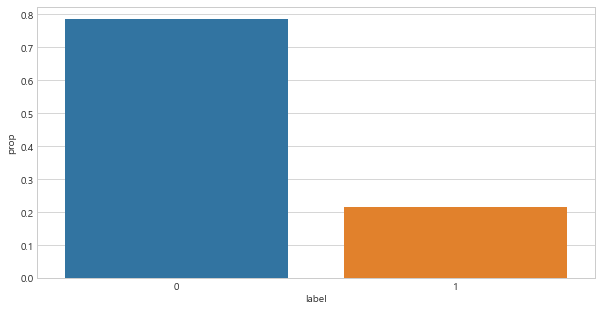

In [206]:
sns.barplot(x = 'label', y='prop', data=ratio01)